# 📊 Projeto – CatBoost

Uma empresa do segmento financeiro deseja aperfeiçoar seu modelo de riscos para clientes pessoa jurídica (empresas),  
de forma que possa conceder créditos para estas empresas com **mais segurança** e **menos exposição a riscos**.

---

Para isso, o time de ciência de dados irá trabalhar uma abordagem capaz de **prever a probabilidade de 3 riscos**:
- 💳 Crédito  
- 🧾 Compliance  
- 📉 Mercado  

Além disso, será feita uma **classificação binária para cada um dos riscos**, sendo também importante entender **quais variáveis influenciam mais em cada risco**, tanto de forma **global quanto individual**.

---

🔍 O projeto contará com um **dataset** contendo:
- Dados das empresas  
- Dados demográficos  
- Dados de rating  
- Informações financeiras  
- Relacionamento com a empresa do segmento financeiro

---

Dada a complexidade do desafio e a quantidade de **variáveis categóricas**, o modelo escolhido será o **ensemble CatBoost**, que será usado para:
- Predizer as variáveis target (riscos)  
- Estimar as probabilidades associadas a cada risco  
- Interpretar as possíveis razões por trás de cada predição

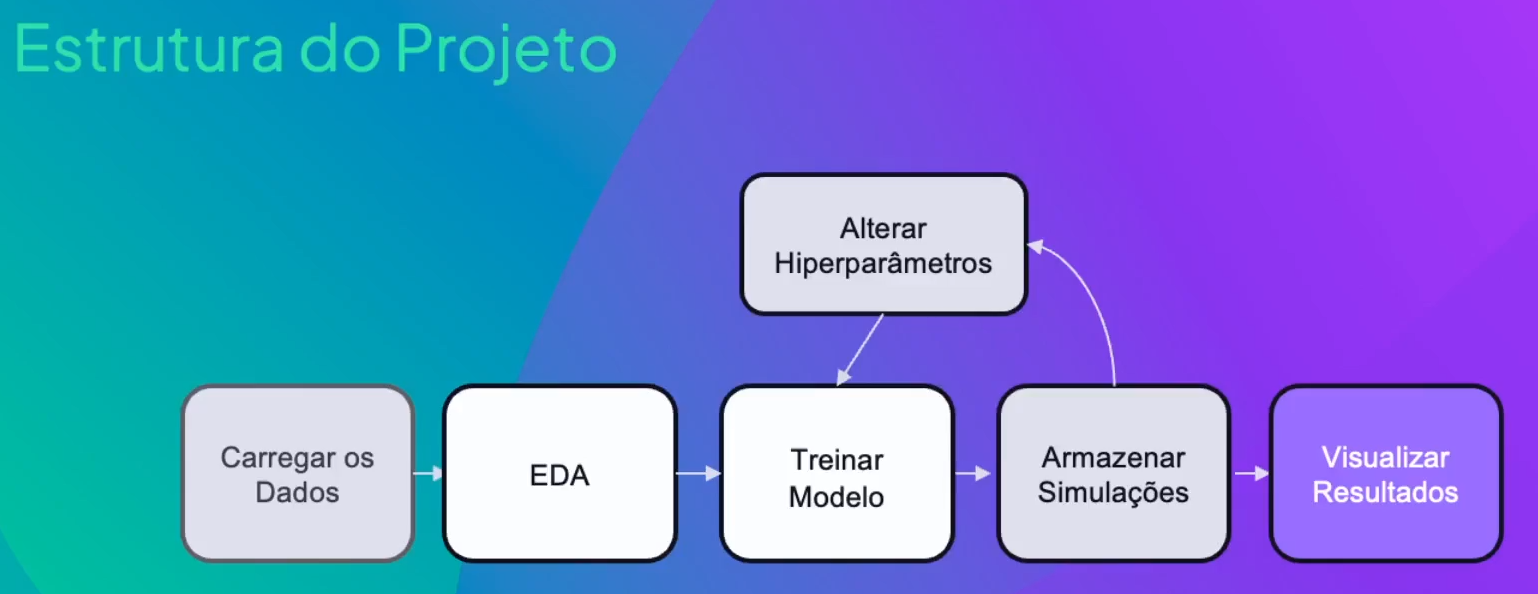

In [33]:
# Importar bibliotecas

# EDA
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from colorama import Fore, Back, Style

# Visualização
import plotly.express as px
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Configurar visualização dos dados
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True, precision=3)

# ML
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score

# Interpretabilidade
import shap

### Carregar os dados

In [2]:
df_empresas = pd.read_csv('./datasets/companies_profile.csv')

### Análise Inicial

In [3]:
# Visualizar a estrutura
df_empresas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         1000 non-null   int64  
 1   Nome_Empresa               1000 non-null   object 
 2   Receita_Anual              1000 non-null   int64  
 3   Margem_Liquida             1000 non-null   float64
 4   Endividamento              1000 non-null   float64
 5   Setor                      1000 non-null   object 
 6   Regiao                     1000 non-null   object 
 7   Tempo_Operacao             1000 non-null   int64  
 8   Auditoria_Externa          1000 non-null   int64  
 9   Rating_Credito             1000 non-null   float64
 10  Tipo_Empresa               1000 non-null   object 
 11  Politica_Sustentabilidade  1000 non-null   object 
 12  Estrategia_Expansao        1000 non-null   object 
 13  Gestao_Risco               1000 non-null   object

In [4]:
# Visualizar primeiras linhas
df_empresas.head(10)

,ID,Nome_Empresa,Receita_Anual,Margem_Liquida,Endividamento,Setor,Regiao,Tempo_Operacao,Auditoria_Externa,Rating_Credito,...,Estrategia_Expansao,Gestao_Risco,Cobertura_Seguros,Maturidade_Digital,Governanca_Corporativa,Cultura_Inovacao,Relacao_Comunidade,Risco_Credito,Risco_Compliance,Risco_Mercado
0,1,Hahn Group,6523388,0.482879,1.032767,Manufatura,Europa,26,0,0.938715,...,Parcerias,Centralizada,Básica,Avançada,Fraca,Neutra,Regular,0,0,0
1,2,Lopez Group,6650634,0.121292,0.492841,Tecnologia,Europa,20,1,0.492362,...,Orgânica,Centralizada,Básica,Inicial,Média,Neutra,Ruim,0,0,0
2,3,Sparks and Sons,4404572,0.190114,0.757099,Manufatura,América Latina,6,0,0.700866,...,Orgânica,Decentralizada,Básica,Inicial,Alta,Neutra,Boa,0,0,0
3,4,"Fields, Ramirez and Craig",2334489,0.402442,2.327962,Manufatura,Europa,6,1,0.855551,...,Parcerias,Centralizada,Nenhuma,Intermediária,Média,Inovadora,Excelente,1,0,0
4,5,"Campbell, Hernandez and Lyons",9624682,0.174549,1.722357,Saúde,América do Norte,18,1,0.418291,...,Aquisições,Decentralizada,Nenhuma,Avançada,Fraca,Neutra,Regular,0,0,0
5,6,Robinson Ltd,7304212,-0.070876,1.290515,Saúde,América do Norte,4,1,0.309413,...,Orgânica,Centralizada,Ampla,Avançada,Alta,Neutra,Ruim,1,0,1
6,7,Bennett LLC,9728519,0.009717,0.130516,Tecnologia,Ásia,17,0,0.936725,...,Parcerias,Decentralizada,Básica,Avançada,Média,Neutra,Regular,0,1,0
7,8,"Rios, Stevens and Johnson",4572471,0.016956,2.481797,Saúde,Europa,14,1,0.515677,...,Parcerias,Centralizada,Nenhuma,Intermediária,Alta,Neutra,Regular,1,0,0
8,9,"Murphy, Walters and Cruz",4623669,0.078123,1.711492,Tecnologia,América Latina,14,0,0.497254,...,Aquisições,Decentralizada,Básica,Avançada,Média,Neutra,Ruim,0,1,0
9,10,Larson Ltd,7504852,0.098752,0.860614,Financeiro,América Latina,13,0,0.178416,...,Aquisições,Centralizada,Básica,Intermediária,Média,Conservadora,Boa,1,1,0


In [5]:
# Visualizar ultimas linhas
df_empresas.tail(10)

,ID,Nome_Empresa,Receita_Anual,Margem_Liquida,Endividamento,Setor,Regiao,Tempo_Operacao,Auditoria_Externa,Rating_Credito,...,Estrategia_Expansao,Gestao_Risco,Cobertura_Seguros,Maturidade_Digital,Governanca_Corporativa,Cultura_Inovacao,Relacao_Comunidade,Risco_Credito,Risco_Compliance,Risco_Mercado
990,991,Meza-Garcia,2701623,0.444208,2.263319,Manufatura,América do Norte,21,0,0.567443,...,Parcerias,Decentralizada,Nenhuma,Inicial,Média,Inovadora,Boa,1,0,0
991,992,Jacobs LLC,9866854,0.164538,0.469137,Manufatura,Europa,39,0,0.377008,...,Orgânica,Decentralizada,Básica,Avançada,Média,Inovadora,Regular,1,0,0
992,993,Smith LLC,6331219,0.231550,2.476207,Tecnologia,Europa,23,0,0.964929,...,Orgânica,Centralizada,Básica,Inicial,Média,Inovadora,Regular,1,0,0
993,994,Erickson Group,4208997,-0.090353,2.391633,Financeiro,América do Norte,27,1,0.273542,...,Aquisições,Centralizada,Nenhuma,Inicial,Fraca,Inovadora,Excelente,1,0,0
994,995,"Wilson, Nicholson and Benson",3464695,-0.169385,1.287220,Saúde,Ásia,45,1,0.399658,...,Parcerias,Centralizada,Nenhuma,Inicial,Média,Neutra,Regular,1,0,0
995,996,Kelley-Ali,1145482,-0.122434,1.330529,Financeiro,América do Norte,44,1,0.982860,...,Parcerias,Decentralizada,Nenhuma,Avançada,Média,Inovadora,Regular,0,0,0
996,997,Sawyer-Phillips,5886265,0.218972,1.255718,Saúde,Europa,18,1,0.536470,...,Orgânica,Decentralizada,Básica,Inicial,Alta,Inovadora,Regular,0,0,0
997,998,"Chang, Dudley and Lee",6008635,-0.133492,1.625065,Tecnologia,Europa,24,1,0.502630,...,Parcerias,Decentralizada,Nenhuma,Intermediária,Alta,Inovadora,Ruim,0,0,0
998,999,Bradshaw Inc,7587345,0.063195,0.317732,Tecnologia,Ásia,47,1,0.257778,...,Aquisições,Centralizada,Ampla,Intermediária,Alta,Neutra,Regular,1,0,0
999,1000,Schneider-Nguyen,9783910,0.185064,0.178283,Saúde,América do Norte,40,0,0.701364,...,Aquisições,Centralizada,Nenhuma,Avançada,Fraca,Inovadora,Ruim,0,0,0


In [6]:
# Valores possiveis para variaveis categoricas
for col in df_empresas.drop(columns=['Nome_Empresa']).select_dtypes(include=['object']).columns:
    print(f'\nValores únicos em {col}:')
    print(df_empresas[col].unique())


Valores únicos em Setor:
['Manufatura' 'Tecnologia' 'Saúde' 'Financeiro']

Valores únicos em Regiao:
['Europa' 'América Latina' 'América do Norte' 'Ásia']

Valores únicos em Tipo_Empresa:
['MEI' 'S.A.' 'Limitada' 'Multinacional']

Valores únicos em Politica_Sustentabilidade:
['Baixa' 'Alta' 'Média']

Valores únicos em Estrategia_Expansao:
['Parcerias' 'Orgânica' 'Aquisições']

Valores únicos em Gestao_Risco:
['Centralizada' 'Decentralizada']

Valores únicos em Cobertura_Seguros:
['Básica' 'Nenhuma' 'Ampla']

Valores únicos em Maturidade_Digital:
['Avançada' 'Inicial' 'Intermediária']

Valores únicos em Governanca_Corporativa:
['Fraca' 'Média' 'Alta']

Valores únicos em Cultura_Inovacao:
['Neutra' 'Inovadora' 'Conservadora']

Valores únicos em Relacao_Comunidade:
['Regular' 'Ruim' 'Boa' 'Excelente']


In [7]:
# Estatisticas das variaveis numericas
df_empresas.describe()

,ID,Receita_Anual,Margem_Liquida,Endividamento,Tempo_Operacao,Auditoria_Externa,Rating_Credito,Risco_Credito,Risco_Compliance,Risco_Mercado
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,4.992928e+06,0.152379,1.317909,25.367000,0.496000,0.487000,0.595000,0.206000,0.110000
std,288.819436,2.804931e+06,0.199511,0.700616,14.103873,0.500234,0.292846,0.491138,0.404633,0.313046
min,1.000000,1.393530e+05,-0.199834,0.100452,1.000000,0.000000,0.000748,0.000000,0.000000,0.000000
25%,250.750000,2.646178e+06,-0.021089,0.691918,13.000000,0.000000,0.232142,0.000000,0.000000,0.000000
50%,500.500000,5.032603e+06,0.160441,1.364206,25.000000,0.000000,0.475893,1.000000,0.000000,0.000000
75%,750.250000,7.270658e+06,0.323736,1.919788,38.000000,1.000000,0.742092,1.000000,0.000000,0.000000
max,1000.000000,9.989550e+06,0.499547,2.499313,49.000000,1.000000,0.999049,1.000000,1.000000,1.000000


### EDA

In [8]:
# Lista de features numericas
features_numericas = df_empresas.drop(columns=['ID', 'Risco_Credito', 'Risco_Compliance', 'Risco_Mercado'], axis=1).select_dtypes(include=['float64', 'int64']).columns
features_numericas

Index(['Receita_Anual', 'Margem_Liquida', 'Endividamento', 'Tempo_Operacao',
       'Auditoria_Externa', 'Rating_Credito'],
      dtype='object')

In [9]:
# Visualizar a distribuicao das features numericas
for col in features_numericas:
    fig = px.histogram(df_empresas, x=col, nbins=20, title=f'Distribuição de {col}')
    fig.show()

In [10]:
# Lista de Features categoricas
features_categoricas = df_empresas.drop(columns=['Nome_Empresa']).select_dtypes(include=['object']).columns
features_categoricas

Index(['Setor', 'Regiao', 'Tipo_Empresa', 'Politica_Sustentabilidade',
       'Estrategia_Expansao', 'Gestao_Risco', 'Cobertura_Seguros',
       'Maturidade_Digital', 'Governanca_Corporativa', 'Cultura_Inovacao',
       'Relacao_Comunidade'],
      dtype='object')

In [11]:
# Contagem de valores para variaveis categoricas
for col in features_categoricas:
    df_count = df_empresas[col].value_counts().reset_index()
    df_count.columns = ['categoria', 'contagem']
    fig = px.bar(df_count,
                 x='categoria',
                 y='contagem',
                 title=f'Distribuição / Contagem de {col}')
    fig.show()

In [12]:
# Lista de Targets
targets = ['Risco_Credito', 'Risco_Compliance', 'Risco_Mercado']

In [13]:
# Visualizar Distribuicao dos targets
for col in targets:
    df_count = df_empresas[col].value_counts().reset_index()
    df_count.columns = ['categoria', 'contagem']
    fig = px.bar(df_count,
                 x='categoria',
                 y='contagem',
                 title=f'Distribuição / Contagem de {col}')
    fig.show()

In [14]:
# Analisar relação entre features numéricas e categóricas e os targets
for target in targets:
    for col in features_numericas:
        fig = px.box(
            df_empresas,
            x=target,
            y=col,
            title=f'{col} por {target}'
        )
        fig.show()

    for col in features_categoricas:
        fig = px.histogram(
            df_empresas,
            x=col,
            color=target,
            barmode='group',
            title=f'{col} por {target}'
        )
        fig.show()

In [15]:
# Matriz de Correlação
correlation_matrix = df_empresas[features_numericas.tolist() + targets].corr()

# Heatmap da matriz de correlação
fig = px.imshow(
    correlation_matrix,
    color_continuous_scale='armyrose',
    title='Matriz de Correlação',
    zmin=-1,
    zmax=1
)

# Ajustes no Heatmap
fig.update_traces(
    text=correlation_matrix,
    texttemplate='%{text:.1%}',
    textfont=dict(size=9)
)

fig.update_layout(
    width=1000,
    height=600,
    title_font=dict(size=14),
    font=dict(size=10)
)

fig.show()

In [16]:
# ANOVA – Análise de Variância (diferença significativa entre média entre 3 ou mais grupos)
# T-Student – (diferença significativa entre média entre 2 grupos)

for col in features_numericas:
    for target in targets:
        groups = [
            df_empresas[df_empresas[target] == val][col]
            for val in df_empresas[target].unique()
        ]
        if df_empresas[target].nunique() <= 2:
            stat, p = ttest_ind(*groups)
            teste = 'T-Test'
        elif df_empresas[target].nunique() > 2:
            stat, p = f_oneway(*groups)
            teste = 'ANOVA'
        print(
            f'{Fore.RED if p < 0.05 else Fore.WHITE}'
            f'{teste} entre {col} e {target}: p-valor = {p}'
        )


T-Test entre Receita_Anual e Risco_Credito: p-valor = 0.9148230907469925
T-Test entre Receita_Anual e Risco_Compliance: p-valor = 0.37245390731630845
T-Test entre Receita_Anual e Risco_Mercado: p-valor = 1.4322662899167404e-06
T-Test entre Margem_Liquida e Risco_Credito: p-valor = 0.714839504289611
T-Test entre Margem_Liquida e Risco_Compliance: p-valor = 7.293209908090928e-67
T-Test entre Margem_Liquida e Risco_Mercado: p-valor = 0.4678700538767202
T-Test entre Endividamento e Risco_Credito: p-valor = 2.0286202656673824e-48
T-Test entre Endividamento e Risco_Compliance: p-valor = 0.028739447727093168
T-Test entre Endividamento e Risco_Mercado: p-valor = 0.6427051699118199
T-Test entre Tempo_Operacao e Risco_Credito: p-valor = 0.7368086294717284
T-Test entre Tempo_Operacao e Risco_Compliance: p-valor = 0.687526198825497
T-Test entre Tempo_Operacao e Risco_Mercado: p-valor = 9.253489005940335e-41
T-Test entre Auditoria_Externa e Risco_Credito: p-valor = 0.12610915002115405
T-Test entre 

### Preparação dos dados

In [17]:
# Separar X e y
lista_colunas_indice = ['ID', 'Nome_Empresa']
X = df_empresas.drop(columns=lista_colunas_indice + targets, axis=1)
y = df_empresas[targets]

In [18]:
# Separar entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=51, shuffle=True)

### Treinamento do Modelo Catboost com abordagem OnevsRest (OnevsAll)

In [19]:
# Criar o objeto Catboost
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.5,
    depth=6,
    l2_leaf_reg=3,
    cat_features=features_categoricas.tolist(),
    random_strength=2,
    loss_function='Logloss'
)

In [20]:
# Colocar o modelo Catboost na abordagem OnevsRest
ovr_model = OneVsRestClassifier(cat_model)

In [21]:
# Treinar o modelo
ovr_model.fit(X_train, y_train)

0:	learn: 0.2862783	total: 185ms	remaining: 3m 4s
1:	learn: 0.0580960	total: 214ms	remaining: 1m 46s
2:	learn: 0.0222291	total: 242ms	remaining: 1m 20s
3:	learn: 0.0158619	total: 270ms	remaining: 1m 7s
4:	learn: 0.0105696	total: 280ms	remaining: 55.8s
5:	learn: 0.0084254	total: 294ms	remaining: 48.7s
6:	learn: 0.0083479	total: 312ms	remaining: 44.3s
7:	learn: 0.0082138	total: 331ms	remaining: 41s
8:	learn: 0.0072821	total: 359ms	remaining: 39.5s
9:	learn: 0.0045464	total: 382ms	remaining: 37.8s
10:	learn: 0.0045464	total: 412ms	remaining: 37s
11:	learn: 0.0045460	total: 453ms	remaining: 37.3s
12:	learn: 0.0039621	total: 492ms	remaining: 37.3s
13:	learn: 0.0039615	total: 502ms	remaining: 35.3s
14:	learn: 0.0029158	total: 530ms	remaining: 34.8s
15:	learn: 0.0029157	total: 558ms	remaining: 34.3s
16:	learn: 0.0024326	total: 587ms	remaining: 34s
17:	learn: 0.0024325	total: 617ms	remaining: 33.7s
18:	learn: 0.0019434	total: 648ms	remaining: 33.5s
19:	learn: 0.0019375	total: 676ms	remaining: 

OneVsRestClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x00000198C5DD5220>)

### Análise dos Resultados e métricas

In [23]:
# Fazer predição das classes com base no modelo
y_pred = ovr_model.predict(X_test)
y_pred

array([[1, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 0],
       [1, 0, 1],
       [0, 0, 0]])

In [26]:
# Fazer a predição das probabilidades com base no modelo
y_pred_proba = ovr_model.predict_proba(X_test)
y_pred_proba

array([[1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   ],
       [0.999, 0.   , 1.   ],
       [0.   , 0.   , 0.   ]])

In [27]:
# Relatório de classificação
print('Relatório de Classificação')
print(classification_report(y_test, y_pred))

Relatório de Classificação
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       0.98      1.00      0.99       105
           2       1.00      1.00      1.00        55

   micro avg       0.99      1.00      1.00       453
   macro avg       0.99      1.00      1.00       453
weighted avg       0.99      1.00      1.00       453
 samples avg       0.71      0.72      0.71       453



c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.

c:\Users\guilh\miniconda3\envs\Projeto_ML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.




Matriz de Confusão para Risco_Credito


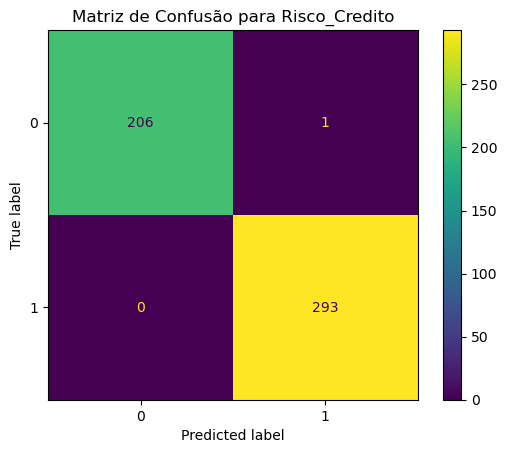


Matriz de Confusão para Risco_Compliance


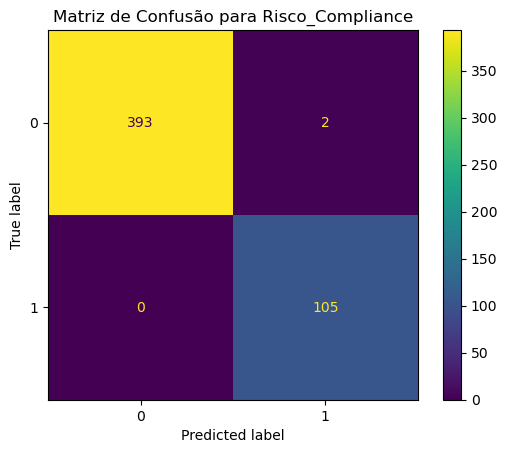


Matriz de Confusão para Risco_Mercado


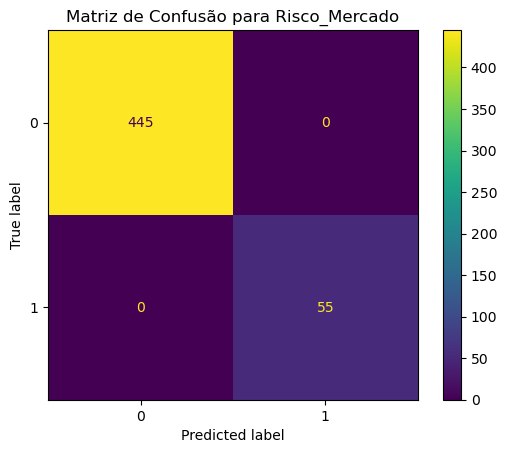

In [28]:
# Mostrar a matriz de confusão para cada classe
for i, target in enumerate(targets):
    print(f'\nMatriz de Confusão para {target}')
    conf_matrix = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    fig = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    fig.plot()
    plt.title(f'Matriz de Confusão para {target}')
    plt.show()

In [29]:
# Calcular o logloss para cada target
print('Log Loss por Target')
for i, target in enumerate(targets):
    log_loss_score = log_loss(y_test.iloc[:, i], y_pred_proba[:, i])
    print(f'{target}: {log_loss_score:.4f}')

Log Loss por Target
Risco_Credito: 0.0071
Risco_Compliance: 0.0098
Risco_Mercado: 0.0001


### Interpretabilidade

In [32]:
# Importância das variáveis - Para cada target

for i, target in enumerate(targets):

    # Obter a importância das features
    importancias = ovr_model.estimators_[i].feature_importances_
    nomes_features = X.columns.tolist()

    # Criar um DataFrame com as importâncias e nomes de features
    df_importancias = pd.DataFrame({'feature': nomes_features, 'importancia': importancias})

    # Ordenar o DataFrame
    df_importancias = df_importancias.sort_values('importancia', ascending=False).reset_index(drop=True)

    # Montar o Plot
    fig = px.bar(
        df_importancias.head(10),
        x='importancia',
        y='feature',
        orientation='h',
        title=f'Importância das 10 principais features – {target}',
        labels={'importancia': 'Importância', 'feature': 'Feature'},
        color='importancia',
        color_continuous_scale='ArmyRose'
    )

    # Personalizar o layout
    fig.update_layout(
        height=600,
        yaxis={'categoryorder': 'total ascending'}
    )

    fig.show()

In [ ]:
# Visualizar exemplo de árvore
modelo_catboost = ovr_model.estimators_[0]

# Criar o Pool com os dados de treinamento
pool = Pool(
    data=X_train,
    label=y_train.iloc[:, 0],
    cat_features=features_categoricas.tolist(),
    feature_names=list(X_train.columns)
)

# Plotar a árvore
modelo_catboost.plot_tree(tree_idx=0, pool=pool)

In [35]:
# Shap Values

# Criar e rodar explainers para cada target
explainers = []
shap_values = []

for i, target in enumerate(targets):
    print(f'Calculando SHAP values para {target}...')

    # Usar TreeExplainer específico pra Catboost
    explainer = shap.TreeExplainer(ovr_model.estimators_[i])

    # Calcular valores SHAP
    shap_values_target = explainer.shap_values(X_test)

    # Atualizo as listas
    explainers.append(explainer)
    shap_values.append(shap_values_target)

Calculando SHAP values para Risco_Credito...
Calculando SHAP values para Risco_Compliance...
Calculando SHAP values para Risco_Mercado...



Gráfico SHAP para Risco_Credito:


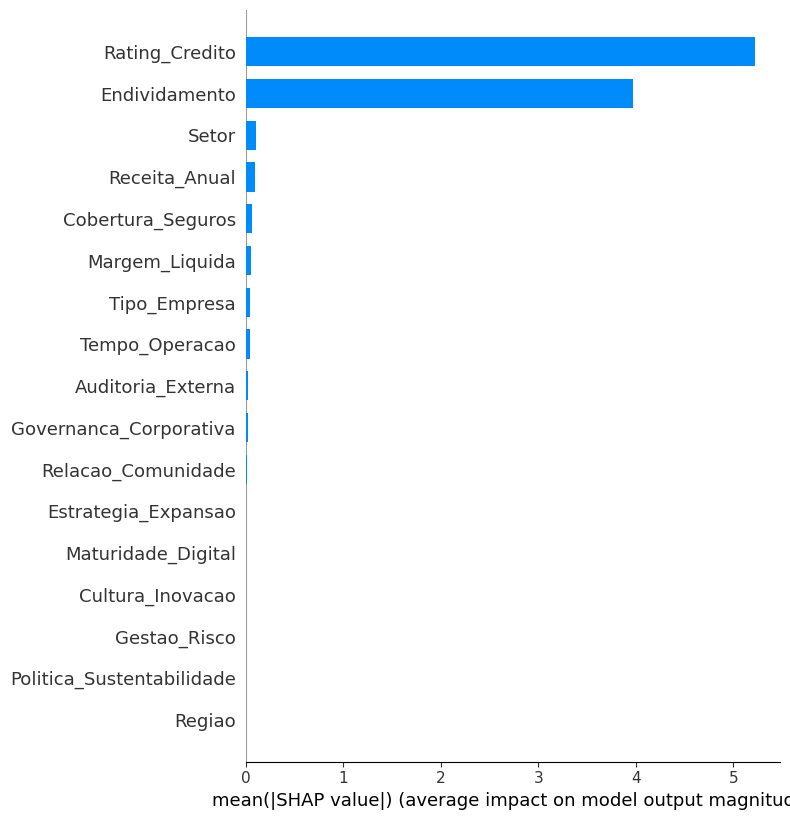

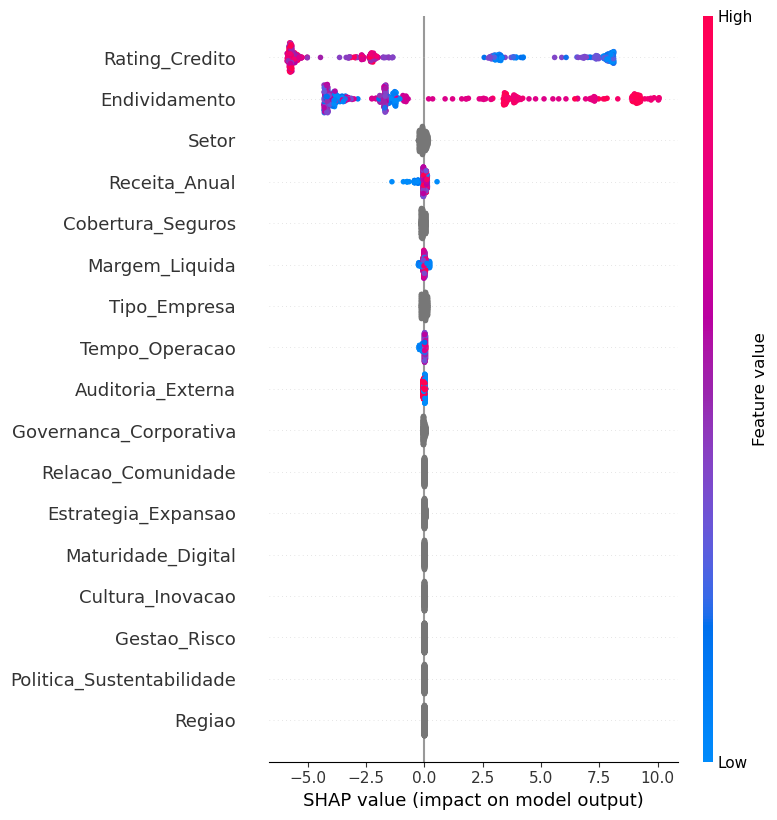


Gráfico SHAP para Risco_Compliance:


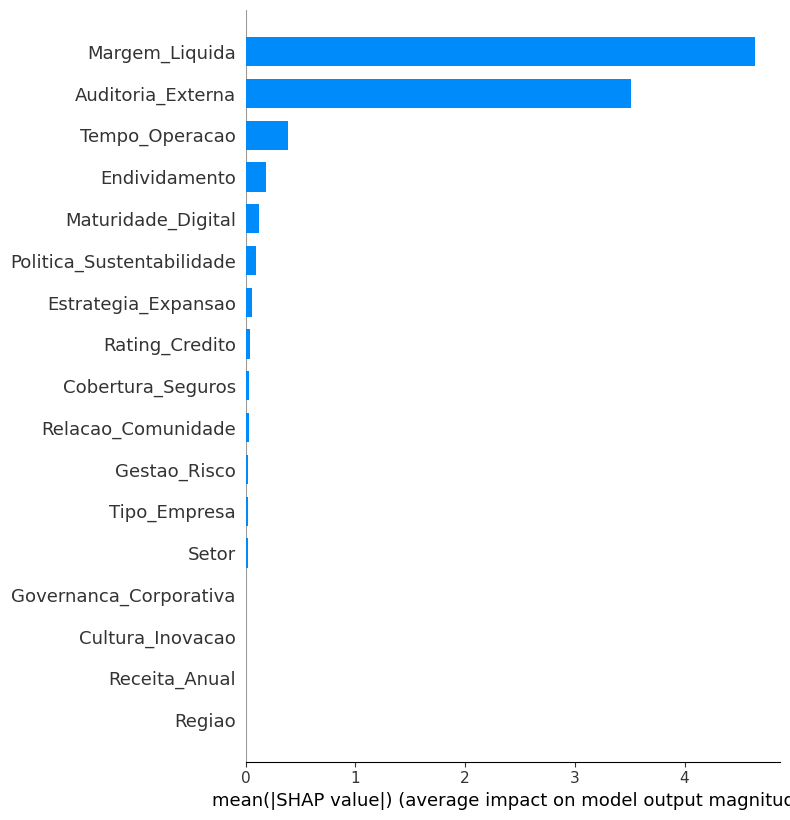

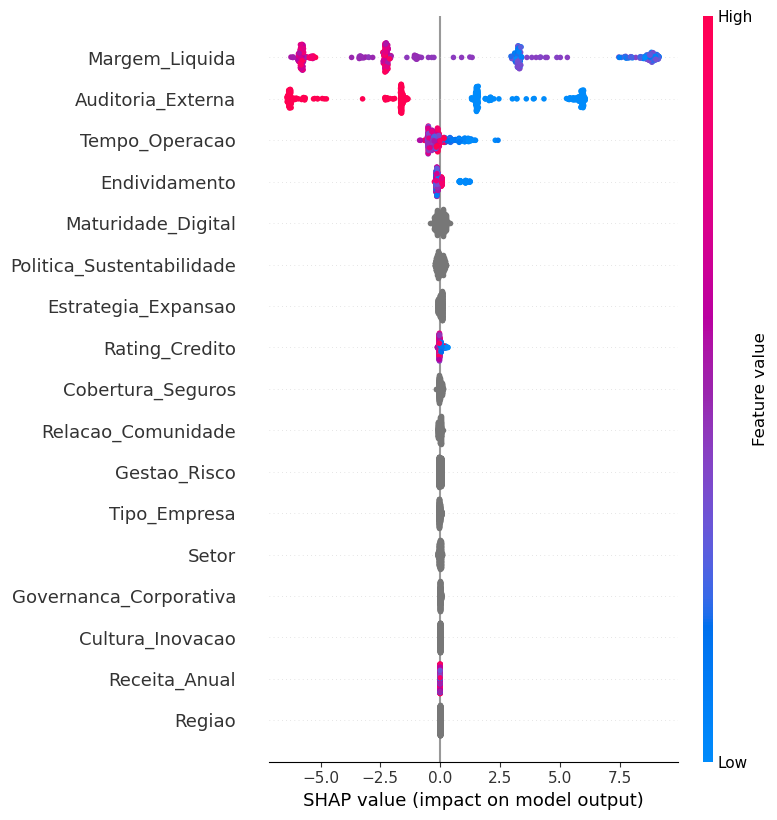


Gráfico SHAP para Risco_Mercado:


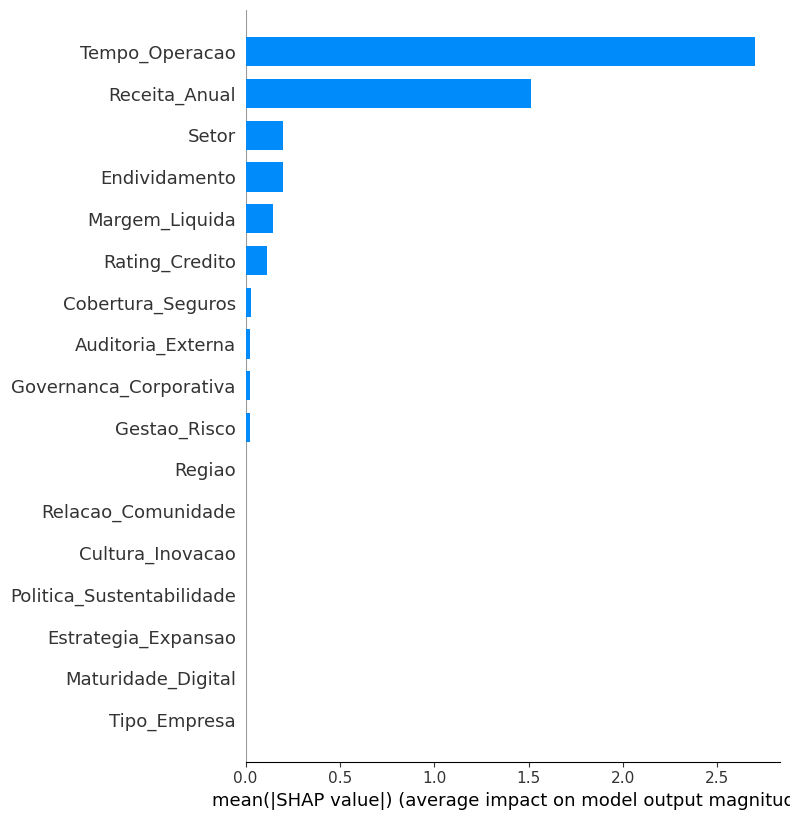

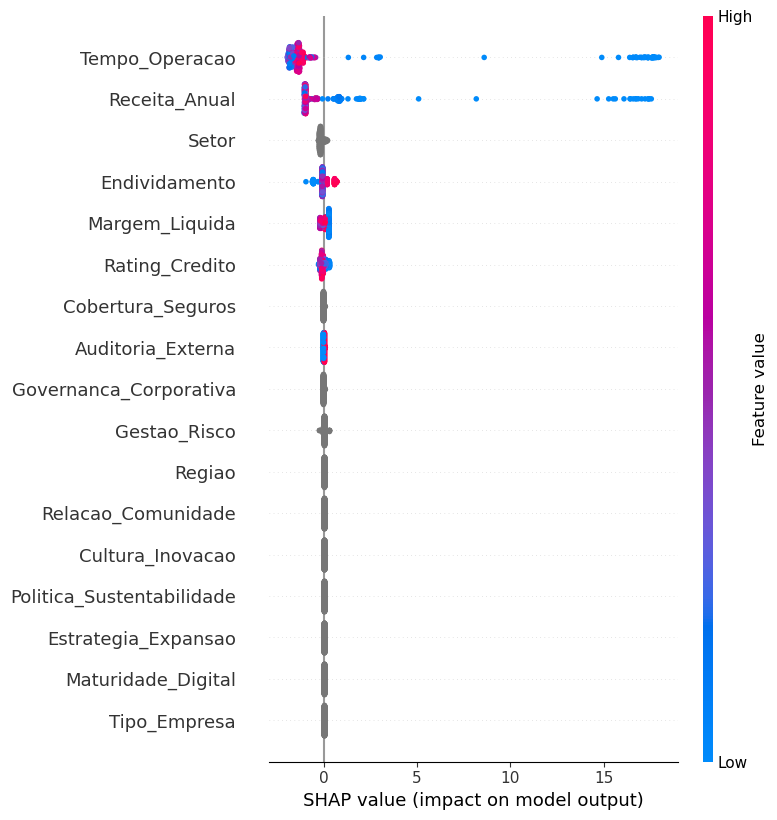

In [36]:
# Plotar gráficos SHAP para cada target
for i, target in enumerate(targets):
    print(f'\nGráfico SHAP para {target}:')

    # Criar o gráfico de resumo de SHAP
    shap.summary_plot(
        shap_values[i],
        X_test,
        plot_type='bar',
        title=f'Contribuição Global das Variáveis – {target}',
        show=False
    )

    plt.tight_layout()
    plt.show()

    # Criar o gráfico de resumo de SHAP
    shap.summary_plot(
        shap_values[i],
        X_test,
        title=f'Distribuição dos Valores SHAP – {target}',
        show=False
    )

    plt.tight_layout()
    plt.show()
